In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import seaborn as sns
import os
import re
import time
import pickle
import pdb
sns.set()

Using TensorFlow backend.


In [2]:
def reading_in_data(filename):
    
    filename = str(filename)

    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    
    return new_dict

def sifting_data_dicts(quasar_dict, star_dict, min_cut, max_cut):
    
    # initial flux, label, wavelength, redshift, and noise for the stars and quasars
    init_quasar_flux = quasar_dict['FLUX']
    init_quasar_labels = quasar_dict['CLASS']
    init_quasar_wave = quasar_dict['WAVE']
    init_quasar_redshift = quasar_dict['REDSHIFT']
    init_quasar_noise = quasar_dict['NOISE']
    
    init_star_flux = star_dict['FLUX']
    init_star_labels = star_dict['CLASS']
    init_star_wave = star_dict['WAVE']
    init_star_redshift = star_dict['REDSHIFT']
    init_star_noise = star_dict['NOISE']
    
    # empty lists to store the flux,labels, wavelength, redshift, and noise for the quasars & stars
    quasar_labels = []
    quasar_flux = []
    quasar_wave = []
    quasar_redshift = []
    quasar_noise = []
    
    star_labels = []
    star_flux = []
    star_wave = []
    star_redshift = []
    star_noise = []

    # check if the classifier actually came back as QSO and if so append to empty list
    for i in range(len(init_quasar_labels)):
        if (init_quasar_labels[i] == 'QSO')  & (min(init_quasar_wave[i]) <= min_cut) & \
        (max(init_quasar_wave[i]) >= max_cut):
            
            quasar_labels.append(init_quasar_labels[i])
            quasar_flux.append(init_quasar_flux[i])
            quasar_wave.append(init_quasar_wave[i])
            quasar_redshift.append(init_quasar_redshift[i])
            quasar_noise.append(init_quasar_noise[i])
            
        else:
            pass
        
    
    # check if the classifier actually came back as star and if so append to empty list
    for i in range(len(init_star_labels)):
        if (init_star_labels[i] == 'STAR') & (min(init_star_wave[i]) <= min_cut) & \
        (max(init_star_wave[i]) >= max_cut):
            
            star_labels.append(init_star_labels[i])
            star_flux.append(init_star_flux[i])
            star_wave.append(init_star_wave[i])
            star_redshift.append(init_star_redshift[i])
            star_noise.append(init_star_noise[i])
        else:
            pass
        
    data_dict = {'STAR_FLUX':star_flux, 'STAR_LABELS': star_labels, 'STAR_WAVE':star_wave, 'STAR_NOISE': star_noise,\
                 'STAR_REDSHIFT':star_redshift, 'QUASAR_FLUX':quasar_flux, 'QUASAR_LABELS':quasar_labels, \
                 'QUASAR_WAVE': quasar_wave, 'QUASAR_NOISE': quasar_noise, 'QUASAR_REDSHIFT': quasar_redshift}
    
    return data_dict


                 


def randomizing_data(data_dict, cut_len):
    
    quasar_flux = data_dict['QUASAR_FLUX'][:cut_len]
    quasar_labels = data_dict['QUASAR_LABELS'][:cut_len]
    quasar_wave = data_dict['QUASAR_WAVE'][:cut_len]
    quasar_noise = data_dict['QUASAR_NOISE'][:cut_len]
    quasar_redshift = data_dict['QUASAR_REDSHIFT'][:cut_len]
    
    star_flux = data_dict['STAR_FLUX'][:cut_len]
    star_labels = data_dict['STAR_LABELS'][:cut_len] 
    star_wave = data_dict['STAR_WAVE'][:cut_len]
    star_noise = data_dict['STAR_NOISE'][:cut_len]
    star_redshift = data_dict['STAR_REDSHIFT'][:cut_len]

    star_labels = np.ones(len(star_labels))
    quasar_labels = np.zeros(len(quasar_labels))
    
    input_flux = star_flux + quasar_flux
    input_flux = np.asarray(input_flux)
    
    input_labels = np.concatenate((star_labels,quasar_labels), axis = 0)
    
    input_wave = star_wave + quasar_wave
    input_wave = np.asarray(input_wave)
    
    input_noise = star_noise + quasar_noise
    input_noise = np.asarray(input_noise)
    
    input_redshift = star_redshift+ quasar_redshift
    input_redshift = np.asarray(input_redshift)
    
    permutation = np.random.permutation(len(input_flux)) # creates the same permutation to be done on flux & labels
    
    # needs to be array to permute for classification
    randomized_flux = input_flux[permutation] 
    randomized_labels = input_labels[permutation]
    randomized_wave = input_wave[permutation]
    randomized_noise = input_noise[permutation]
    randomized_redshift = input_redshift[permutation]

    randomized_flux = randomized_flux.tolist() # needs to be a list to be used in creating tensor function
    
    randomized_data = {'FLUX': randomized_flux, 'LABELS': randomized_labels, 'WAVE': randomized_wave,\
                      'NOISE': randomized_noise, 'REDSHIFT': randomized_redshift, 'PERMUTATION': permutation}
    
    return randomized_data

def normalizing_data(data_dict):
    
    flux = data_dict['FLUX']
    labels = data_dict['LABELS']
    wave = data_dict['WAVE']
    redshift = data_dict['REDSHIFT']
    
    max_flux = []
    normalized_flux = []

    for i in range(len(flux)):
    
        max_flux.append(max(flux[i]))
        
        edited_flux = flux[i]/max_flux[i]
    
        normalized_flux.append(edited_flux)
        
    data = {'FLUX': normalized_flux, 'LABELS': labels, 'WAVE': wave, 'REDSHIFT': redshift}
    
    return data

def creating_image_dims(data_dict):
    
    flux = data_dict['FLUX']
    wave = data_dict['WAVE']
    labels = data_dict['LABELS']
    redshift = data_dict['REDSHIFT']
    cut_spec = []
    cut_wave = []
    
    for i in range(len(flux)): # 3.5817
        spec = flux[i]
        wavelength = wave[i]
        keepidx, = np.where((wave[i] > 3.5818) & (wave[i] < 3.95))
        cut_spec.append(spec[keepidx])
        cut_wave.append(wavelength[keepidx])
    
    data = {'FLUX': cut_spec, 'LABELS': labels, 'WAVE': cut_wave, 'REDSHIFT': redshift} #'FLUX': speclen_same
    
    return data
          

def creating_input_tensor(samples, height , width , channels , data_dict):
    
    # creates input tensor of correct dimensions
    input_tensor = np.ones((samples, height, width, channels))
    
    # brings in preprocessed data to input into the dimensions of the tensor
    processed_data = creating_image_dims(normalized_data)
    
    # creating the list of the same length fluxs
    fluxlen_same = processed_data['FLUX']
    
    # putting the length of the fluxs lists into the first axis of the tensor, while filling the 3rd axis
    # with that specific samples flux array
    for i in range(samples):
        spec = fluxlen_same[i]
        input_tensor[i,0,:,0] = spec[:]
        
    data = {'IMAGES': input_tensor, 'LABELS': processed_data['LABELS']}
        
    return data


def save_data_to_disk(name_file, saved_variable):
    
    filename = str(name_file)
    outfile = open(filename,'wb')
    
    pickle.dump(saved_variable,outfile)
    outfile.close()

In [3]:
quasar_dict = reading_in_data('quasar_data')

star_dict = reading_in_data('star_data')

In [4]:
sifted_data_dict = sifting_data_dicts(quasar_dict, star_dict, 3.5818, 3.95) #3.5818, 3.95)

In [5]:
randomized_data = randomizing_data(sifted_data_dict, 6986)

In [6]:
normalized_data = normalizing_data(randomized_data)

In [16]:
wave = normalized_data['WAVE']
flux = normalized_data['FLUX']


print(len(wave[0]))
print(len(wave[9000]))

4615
4591


In [17]:
print(len(normalized_data['FLUX'][4]))

4601


In [20]:
image_data = creating_image_dims(normalized_data)

In [21]:
wave = image_data['WAVE']
print(len(wave[0]))
print(len(wave[9000]))

3681
3681


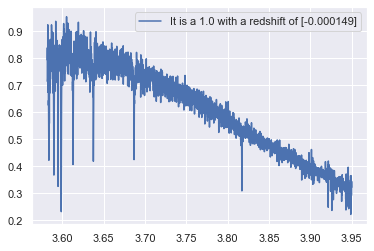

In [22]:
wave = image_data['WAVE']
flux = image_data['FLUX']
label = image_data['LABELS']
z = image_data['REDSHIFT']

# 1 is star, 0 is quasar

#plt.plot(wave[17], flux[17], label = "It is a "+str(label[17])+" with a redshift of "+str(z[17]))
plt.plot(wave[1], flux[1], label = "It is a "+str(label[1])+" with a redshift of "+str(z[1]))  
plt.legend()

In [23]:
#save_data_to_disk('plot_data', image_data)

In [24]:
input_data = creating_input_tensor(13972, 1, 3681 , 1, normalized_data)

In [25]:
np.shape(input_data['IMAGES'])

(13972, 1, 3681, 1)

In [26]:
np.shape(input_data['LABELS'])

(13972,)

In [27]:
save_data_to_disk('preprocessed_data1', input_data)